In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [167]:
application_train = pd.read_csv('../input/home-credit-default-risk/application_train_new.csv')
bureau = pd.read_csv('../input/home-credit-default-risk/bureau_new.csv')
bureau_balance = pd.read_csv('../input/home-credit-default-risk/bureau_balance_new.csv')
credit_card_balance = pd.read_csv('../input/home-credit-default-risk/credit_card_balance_new.csv')
installments_payments = pd.read_csv('../input/home-credit-default-risk/installments_payments_new.csv')
pos_cash_balance = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance_new.csv')
previous_application = pd.read_csv('../input/home-credit-default-risk/previous_application_new.csv')

In [168]:
print("Shape of application_train", application_train.shape)
print("Shape of bureau", bureau.shape)
print("Shape of bureau_balance", bureau_balance.shape)
print("Shape of credit_card_balance", credit_card_balance.shape)
print("Shape of installments_payments", installments_payments.shape)
print("Shape of pos_cash_balance", pos_cash_balance.shape)
print("Shape of previous_application", previous_application.shape)

Shape of application_train (307511, 30)
Shape of bureau (1716428, 9)
Shape of bureau_balance (27299925, 3)
Shape of credit_card_balance (3840312, 10)
Shape of installments_payments (13605401, 6)
Shape of pos_cash_balance (10001358, 8)
Shape of previous_application (1670214, 25)


# Bureau

Before we merge data with bureau, we need to merge bureau dataframe with related information in bureau_balance file

What is the exact problem here:

* Bureau dataframe comes from the Credit Bureau authority and displays one row for each credit the client from train/test dataset has taken previously. It is matched by SK_ID_CURR with train/test and where in train/test the SK_ID_CURR do not duplicate (1 for 1 client whom we are trying to classify) in most cases bureau dataframe has multipe indicies of the same client as he/she had applied to multiple loans previously.
* In turn bureau_balance even more extends the previous credit information on a greater scale. It contains a separate row for each month of history of every previous credit reported to Credit Bureau (bureau dataframe) and is related to bureau df via SK_ID_BUREAU.
So the approach we are going to use is to calculate mean of each statistical column out of these both dataframes to include these mean values as features of our clients whom we are trying to classify. 

Steps that we need to take:

1. Collapse bureau_balance dataframe to mean values grouped by SK_ID_BUREAU
2. Merge this with bureau dataframe
3. Collapse bureau dataframe to mean values grouped by SK_ID_CURR
4. Merge what we've got with our data df

In [169]:
# Calculate number of loans of each clients
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

,SK_ID_CURR,PREVIOUS_LOANS_COUNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [170]:
# Merge column to dataframe
data = application_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_3,PREVIOUS_LOANS_COUNT
0,100002.0,1.0,Cash loans,M,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,...,0.0,Laborers,1.0,WEDNESDAY,Business Entity Type 3,0.083037,0.262949,0.139376,1.0,8.0
1,100003.0,0.0,Cash loans,F,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,...,0.0,Core staff,2.0,MONDAY,School,0.311267,0.622246,0.746300,1.0,4.0
2,100004.0,0.0,Revolving loans,M,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,...,0.0,Laborers,1.0,MONDAY,Government,0.356323,0.555912,0.729567,0.0,2.0
3,100006.0,0.0,Cash loans,F,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,...,0.0,Laborers,2.0,WEDNESDAY,Business Entity Type 3,0.356323,0.650442,0.746300,1.0,NaN
4,100007.0,0.0,Cash loans,M,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,...,0.0,Core staff,1.0,THURSDAY,Religion,0.356323,0.322738,0.746300,0.0,1.0


Now back to merging with all the bureau and bureau_balance information

STEP 1 - collapse bureau_balance

In [171]:
# first define the formula for grouping rows by ID and calculating mean values
def extract_mean(x):
    y = x.groupby('SK_ID_BUREAU', as_index=False).mean()
    return y

In [172]:
# apply formula to create bureau_balance dataframe grouped by SK_ID_BUREAU with mean values of all numerical columns
bureau_balance_mean = extract_mean(bureau_balance)

In [173]:
bureau_balance_mean.head()

,SK_ID_BUREAU,MONTHS_BALANCE
0,5001709,-48.0
1,5001710,-41.0
2,5001711,-1.5
3,5001712,-9.0
4,5001713,-10.5


STEP 2 - merge with bureau



In [174]:
bureau = bureau.merge(bureau_balance_mean, on = 'SK_ID_BUREAU', how = 'left')
bureau.drop('SK_ID_BUREAU', axis = 1, inplace = True) # we don't need this internal ID anymore

STEP 3 - collapse bureau

In [175]:
def extract_mean(x):
    y = x.groupby('SK_ID_CURR', as_index=False).mean()
    return y

In [176]:
bureau_mean_values = extract_mean(bureau)

In [177]:
bureau_mean_values.head()

,SK_ID_CURR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT_UPDATE,MONTHS_BALANCE
0,100001,-735.000000,82.428571,-825.500000,207623.571429,85240.928571,0.00000,-93.142857,-11.785714
1,100002,-874.000000,-349.000000,-697.500000,108131.945625,49156.200000,7997.14125,-499.875000,-21.875000
2,100003,-1400.750000,-544.500000,-1097.333333,254350.125000,0.000000,202500.00000,-816.000000,NaN
3,100004,-867.000000,-488.500000,-532.500000,94518.900000,0.000000,0.00000,-532.000000,NaN
4,100005,-190.666667,439.333333,-123.000000,219042.000000,189469.500000,0.00000,-54.333333,-3.000000


STEP 4 - merge bureau with data

In [178]:
data.shape

(307511, 31)

In [179]:
data = data.merge(bureau_mean_values, on = 'SK_ID_CURR', how = 'left')

In [180]:
data.shape

(307511, 39)

# Previous Application

These 4 datasets have their own key to for internal mapping - SK_ID_PREV

So the plan here would be the following:

1. Collapse credit_card_balance dataframe to mean values grouped by SK_ID_PREV
2. Merge with previous_application (our 'leading' dataset in this case)
3. Collapse POS_CASH_balance to mean values grouped by SK_ID_PREV
4. Merge with previous_application
5. Collapse installments_payments ...
6. Merge with previous_application
7. Collapse the resulting previous_application dataset to mean values grouped by SK_ID_CURR
8. Merge our unfolded previous_application statistics with our data

We will delete the SK_ID_CURR from the credit_card_balance / POS_CASH_balance / installment_payments as we do not need this column to be shown as mean, this information has no impact on statistics and will just clutter the space as noise. We will group them with our 'leading' dataset previous_application using SK_ID_PREV and our 'leading' dataset has this SK_ID_CURR key to be further mapped with our data

In [181]:
credit_card_balance.drop('SK_ID_CURR', axis=1, inplace=True)
installments_payments.drop('SK_ID_CURR', axis=1, inplace=True)
pos_cash_balance.drop('SK_ID_CURR', axis=1, inplace=True)

Let's extract the number of previous applications of the clients to Home Credit and add this feature to our data

In [182]:
previous_application_counts = previous_application.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()

,SK_ID_CURR,PREVIOUS_APPLICATION_COUNT
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [183]:
# and throw that column in our data
data = data.merge(previous_application_counts, on = 'SK_ID_CURR', how = 'left')

In [184]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,PREVIOUS_LOANS_COUNT,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT_UPDATE,MONTHS_BALANCE,PREVIOUS_APPLICATION_COUNT
0,100002.0,1.0,Cash loans,M,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,...,8.0,-874.00,-349.0,-697.500000,108131.945625,49156.2,7997.14125,-499.875,-21.875,1.0
1,100003.0,0.0,Cash loans,F,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,...,4.0,-1400.75,-544.5,-1097.333333,254350.125000,0.0,202500.00000,-816.000,NaN,3.0
2,100004.0,0.0,Revolving loans,M,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,...,2.0,-867.00,-488.5,-532.500000,94518.900000,0.0,0.00000,-532.000,NaN,1.0
3,100006.0,0.0,Cash loans,F,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
4,100007.0,0.0,Cash loans,M,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,...,1.0,-1149.00,-783.0,-783.000000,146250.000000,0.0,0.00000,-783.000,NaN,6.0


STEP 1 - collapse credit_card_balance

In [185]:
def extract_mean(x):
    y = x.groupby('SK_ID_PREV', as_index=False).mean()
    return y

In [186]:
credit_card_balance_mean = extract_mean(credit_card_balance)

STEP 2 - merge with previous_application



In [187]:
previous_application = previous_application.merge(credit_card_balance_mean, on = 'SK_ID_PREV', how = 'left')

In [188]:
previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,MONTHS_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,SATURDAY,15,Y,...,Connectivity,middle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,THURSDAY,11,Y,...,XNA,low_action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,112500.0,TUESDAY,11,Y,...,XNA,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,450000.0,MONDAY,7,Y,...,XNA,middle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,337500.0,THURSDAY,9,Y,...,XNA,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,267295.5,WEDNESDAY,12,Y,...,Furniture,low_normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,87750.0,TUESDAY,15,Y,...,Furniture,middle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,105237.0,MONDAY,12,Y,...,Consumer electronics,low_normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,180000.0,WEDNESDAY,9,Y,...,XNA,low_normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


STEP 3 - collapse installments_payments

In [189]:
def extract_mean(x):
    y = x.groupby('SK_ID_PREV', as_index=False).mean()
    return y

In [190]:
install_pay_mean = extract_mean(installments_payments)

In [191]:
install_pay_mean

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,AMT_INSTALMENT
0,1000001,1.500000,1.500000,-253.000000,34221.712500
1,1000002,1.250000,2.500000,-1555.000000,9308.891250
2,1000003,1.000000,2.000000,-64.000000,4951.350000
3,1000004,1.142857,4.000000,-772.000000,4789.022143
4,1000005,1.000000,5.818182,-1543.454545,14703.210000
...,...,...,...,...,...
997747,2843495,1.142857,4.000000,-349.000000,113932.883571
997748,2843496,0.000000,16.235294,-258.058824,9186.311912
997749,2843497,1.000000,10.500000,-303.000000,9175.185000
997750,2843498,1.333333,3.500000,-1367.666667,69053.572500


STEP 4 - merge with previous application

In [192]:
previous_application = previous_application.merge(install_pay_mean, on = 'SK_ID_PREV', how = 'left')

In [193]:
previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,AMT_INSTALMENT
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,SATURDAY,15,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,-42.000000,17284.275000
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,THURSDAY,11,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,3.000000,-74.000000,25188.615000
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,112500.0,TUESDAY,11,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,5.000000,-151.000000,15060.735000
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,450000.0,MONDAY,7,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,1.090909,6.000000,-332.000000,51193.943182
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,337500.0,THURSDAY,9,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,267295.5,WEDNESDAY,12,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,1.166667,3.500000,-433.000000,58960.597500
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,87750.0,TUESDAY,15,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,1.090909,6.000000,-1454.000000,7206.533182
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,105237.0,MONDAY,12,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,5.500000,-1322.000000,11518.857000
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,180000.0,WEDNESDAY,9,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,6.500000,-990.000000,18819.555000


STEP 5 - collapse POS_CASH_balance

In [194]:
def extract_mean(x):
    y = x.groupby('SK_ID_PREV', as_index=False).mean()
    return y

In [195]:
pos_mean = extract_mean(pos_cash_balance)

In [196]:
pos_mean

,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
0,1000001,-9.0,8.666667,7.666667,0.0,0.0
1,1000002,-52.0,5.200000,2.000000,0.0,0.0
2,1000003,-2.5,12.000000,10.500000,0.0,0.0
3,1000004,-25.5,9.625000,6.125000,0.0,0.0
4,1000005,-51.0,10.000000,5.000000,0.0,0.0
...,...,...,...,...,...,...
936320,2843494,-25.0,32.666667,31.666667,0.0,0.0
936321,2843495,-12.5,53.375000,49.875000,0.0,0.0
936322,2843497,-11.0,24.000000,14.000000,0.0,0.0
936323,2843498,-45.0,27.428571,24.285714,0.0,0.0


STEP 6 - merge with previous_application

In [197]:
previous_application = previous_application.merge(pos_mean, on = 'SK_ID_PREV', how = 'left')

In [198]:
previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,CNT_INSTALMENT_MATURE_CUM,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,AMT_INSTALMENT,MONTHS_BALANCE_y,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,SATURDAY,15,Y,...,NaN,2.000000,1.000000,-42.000000,17284.275000,-1.5,6.500000,6.000000,0.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,THURSDAY,11,Y,...,NaN,1.000000,3.000000,-74.000000,25188.615000,-4.0,36.000000,34.000000,0.0,0.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,112500.0,TUESDAY,11,Y,...,NaN,1.000000,5.000000,-151.000000,15060.735000,-5.5,12.000000,7.500000,0.0,0.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,450000.0,MONDAY,7,Y,...,NaN,1.090909,6.000000,-332.000000,51193.943182,-11.5,11.916667,6.416667,0.0,0.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,337500.0,THURSDAY,9,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,267295.5,WEDNESDAY,12,Y,...,NaN,1.166667,3.500000,-433.000000,58960.597500,-14.5,24.000000,21.375000,0.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,87750.0,TUESDAY,15,Y,...,NaN,1.090909,6.000000,-1454.000000,7206.533182,-49.0,11.923077,6.846154,0.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,105237.0,MONDAY,12,Y,...,NaN,1.000000,5.500000,-1322.000000,11518.857000,-44.0,10.000000,5.000000,0.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,180000.0,WEDNESDAY,9,Y,...,NaN,1.000000,6.500000,-990.000000,18819.555000,-32.0,12.000000,5.153846,0.0,0.0


STEP 7 - collapse the resulting previous_application dataset to show mean values grouped by SK_ID_CURR

In [199]:
def extract_mean(x):
    y = x.groupby('SK_ID_CURR', as_index=False).mean()
    return y

In [200]:
prev_appl_mean = extract_mean(previous_application)
prev_appl_mean = prev_appl_mean.drop('SK_ID_PREV', axis = 1) # we don't need this intermediate column any more

In [201]:
prev_appl_mean

,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,DAYS_DECISION,MONTHS_BALANCE_x,...,CNT_INSTALMENT_MATURE_CUM,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,AMT_INSTALMENT,MONTHS_BALANCE_y,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
0,100001,3951.000000,24835.500,23787.00,24835.500,13.000000,1.0,0.104326,-1740.000,NaN,...,NaN,1.250000,2.500000,-1664.000000,7312.725000,-55.000000,4.000000,2.000000,0.000000,0.000000
1,100002,9251.775000,179055.000,179055.00,179055.000,9.000000,1.0,0.000000,-606.000,NaN,...,NaN,1.052632,10.000000,-295.000000,11559.247105,-10.000000,24.000000,15.000000,0.000000,0.000000
2,100003,56553.990000,435436.500,484191.00,435436.500,14.666667,1.0,0.050030,-1305.000,NaN,...,NaN,1.047619,4.666667,-1164.333333,78558.479286,-39.166667,9.791667,5.666667,0.000000,0.000000
3,100004,5357.250000,24282.000,20106.00,24282.000,5.000000,1.0,0.212008,-815.000,NaN,...,NaN,1.333333,2.000000,-754.000000,7096.155000,-25.500000,3.750000,2.250000,0.000000,0.000000
4,100005,4813.200000,22308.750,20076.75,44617.500,10.500000,1.0,0.108964,-536.000,NaN,...,NaN,1.111111,5.000000,-586.000000,6240.205000,-20.000000,11.700000,7.200000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,6605.910000,40455.000,40455.00,40455.000,17.000000,1.0,0.000000,-273.000,NaN,...,NaN,1.142857,4.000000,-120.000000,7492.924286,-5.000000,7.875000,4.375000,0.000000,0.000000
338853,456252,10074.465000,57595.500,56821.50,57595.500,10.000000,1.0,0.062443,-2497.000,NaN,...,NaN,1.000000,3.500000,-2391.000000,10069.867500,-79.000000,6.000000,3.000000,0.000000,0.000000
338854,456253,4770.405000,24162.750,20625.75,24162.750,11.500000,1.0,0.214316,-2380.000,NaN,...,NaN,1.000000,3.050000,-2277.500000,4770.906000,-75.750000,5.000000,2.333333,0.416667,0.416667
338855,456254,10681.132500,121317.750,134439.75,121317.750,15.000000,1.0,0.000000,-299.500,NaN,...,NaN,1.000000,5.250000,-141.500000,10681.132500,-5.500000,15.000000,10.500000,0.000000,0.000000


STEP 7 - merge what we've got with our data


In [202]:
print('data shape', data.shape)
print('previous applications statistics shape', prev_appl_mean.shape)

data shape (307511, 40)
previous applications statistics shape (338857, 26)


In [203]:
data = data.merge(prev_appl_mean, on = 'SK_ID_CURR', how = 'left')

In [204]:
data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,CNT_INSTALMENT_MATURE_CUM,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,AMT_INSTALMENT,MONTHS_BALANCE_y,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
0,100002.0,1.0,Cash loans,M,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,...,NaN,1.052632,10.000000,-295.000000,11559.247105,-10.000000,24.000000,15.000000,0.000000,0.000000
1,100003.0,0.0,Cash loans,F,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,...,NaN,1.047619,4.666667,-1164.333333,78558.479286,-39.166667,9.791667,5.666667,0.000000,0.000000
2,100004.0,0.0,Revolving loans,M,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,...,NaN,1.333333,2.000000,-754.000000,7096.155000,-25.500000,3.750000,2.250000,0.000000,0.000000
3,100006.0,0.0,Cash loans,F,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,...,0.0,1.400000,3.166667,-260.666667,241944.225000,-9.000000,12.888889,10.214286,0.000000,0.000000
4,100007.0,0.0,Cash loans,M,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,...,NaN,1.129412,6.843956,-1087.881319,12122.995738,-36.100000,15.066667,8.966667,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,0.0,Cash loans,M,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,...,NaN,1.142857,4.000000,-120.000000,7492.924286,-5.000000,7.875000,4.375000,0.000000,0.000000
307507,456252.0,0.0,Cash loans,F,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,...,NaN,1.000000,3.500000,-2391.000000,10069.867500,-79.000000,6.000000,3.000000,0.000000,0.000000
307508,456253.0,0.0,Cash loans,F,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,...,NaN,1.000000,3.050000,-2277.500000,4770.906000,-75.750000,5.000000,2.333333,0.416667,0.416667
307509,456254.0,1.0,Cash loans,F,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,...,NaN,1.000000,5.250000,-141.500000,10681.132500,-5.500000,15.000000,10.500000,0.000000,0.000000


# After Merging

In [205]:
(data.isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)

AMT_DRAWINGS_CURRENT         74.656516
AMT_CREDIT_LIMIT_ACTUAL      74.656516
CNT_INSTALMENT_MATURE_CUM    74.656516
CNT_DRAWINGS_CURRENT         74.656516
AMT_TOTAL_RECEIVABLE         74.656516
                               ...    
FLAG_EMP_PHONE                0.000000
FLAG_MOBIL                    0.000000
DAYS_ID_PUBLISH               0.000000
DAYS_REGISTRATION             0.000000
SK_ID_CURR                    0.000000
Length: 65, dtype: float64

In [206]:
# drop columns having more than 65% null values
data.dropna(thresh=data.shape[0]*0.35, axis=1, inplace=True)

In [207]:
data.shape

(307511, 56)

In [208]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,DAYS_DECISION,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,AMT_INSTALMENT,MONTHS_BALANCE_y,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
0,100002.0,1.0,Cash loans,M,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,...,-606.000000,1.052632,10.000000,-295.000000,11559.247105,-10.000000,24.000000,15.000000,0.0,0.0
1,100003.0,0.0,Cash loans,F,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,...,-1305.000000,1.047619,4.666667,-1164.333333,78558.479286,-39.166667,9.791667,5.666667,0.0,0.0
2,100004.0,0.0,Revolving loans,M,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,...,-815.000000,1.333333,2.000000,-754.000000,7096.155000,-25.500000,3.750000,2.250000,0.0,0.0
3,100006.0,0.0,Cash loans,F,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,...,-272.444444,1.400000,3.166667,-260.666667,241944.225000,-9.000000,12.888889,10.214286,0.0,0.0
4,100007.0,0.0,Cash loans,M,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,...,-1222.833333,1.129412,6.843956,-1087.881319,12122.995738,-36.100000,15.066667,8.966667,0.0,0.0


In [209]:
data['SK_DPD'].value_counts()

0.000000      235526
0.500000         565
0.250000         562
0.166667         531
0.083333         505
               ...  
182.507576         1
0.183838           1
12.700000          1
15.578947          1
0.252857           1
Name: SK_DPD, Length: 13133, dtype: int64

In [210]:
data['SK_DPD_DEF'].value_counts()

0.000000    248806
0.083333       533
0.166667       504
0.250000       489
0.500000       450
             ...  
0.036232         1
0.155172         1
0.633333         1
0.355311         1
0.252857         1
Name: SK_DPD_DEF, Length: 7241, dtype: int64

In [211]:
# drop 2 columns since most of values are 0
data.drop(['SK_DPD', 'SK_DPD_DEF'], axis=1, inplace=True)

In [212]:
data.shape

(307511, 54)

In [213]:
data.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'FLAG_DOCUMENT_3', 'PREVIOUS_LOANS_COUNT', 'DAYS_CREDIT',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'DAYS_CREDIT_UPDATE',
       'PREVIOUS_APPLICATION_COUNT', 'AMT_ANNUITY_y', 'AMT_APPLICATION',
       'AMT_CREDIT_y', 'AMT_GOODS_PRICE_y', 'HOUR_APPR_PROCESS_START',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAY

In [214]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
data.drop(to_drop, axis=1, inplace=True)

In [215]:
data.shape

(307511, 50)

In [216]:
data.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_3',
       'PREVIOUS_LOANS_COUNT', 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'DAYS_CREDIT_UPDATE',
       'PREVIOUS_APPLICATION_COUNT', 'AMT_ANNUITY_y', 'AMT_APPLICATION',
       'AMT_GOODS_PRICE_y', 'HOUR_APPR_PROCESS_START',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'DAYS_DECISION',
       'NUM_I

In [217]:
data.dtypes.value_counts()

float64    40
object     10
dtype: int64

In [218]:
# Since we have analyzed the columns in application_train before, now we only need to analyze the meaning of the other columns to TARGET column
categorical_list = []
numerical_list = []
for i in data.iloc[:, 30:].columns.tolist():
    if data[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)

In [219]:
numerical_list

['DAYS_CREDIT',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'DAYS_CREDIT_UPDATE',
 'PREVIOUS_APPLICATION_COUNT',
 'AMT_ANNUITY_y',
 'AMT_APPLICATION',
 'AMT_GOODS_PRICE_y',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'DAYS_DECISION',
 'NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_INSTALMENT',
 'AMT_INSTALMENT',
 'CNT_INSTALMENT']

In [220]:
data.drop('NFLAG_LAST_APPL_IN_DAY', axis=1, inplace=True)

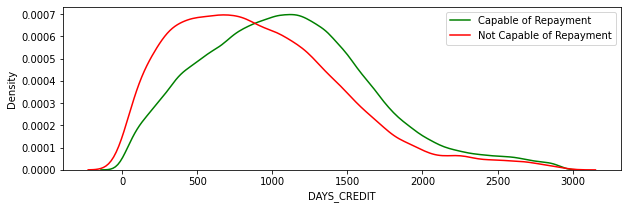

In [221]:
days_credit_approved = - data[data['TARGET'] == 0]['DAYS_CREDIT']
days_credit_rejected = - data[data['TARGET'] == 1]['DAYS_CREDIT']
plt.figure(figsize=(10,3))
sns.distplot(days_credit_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(days_credit_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

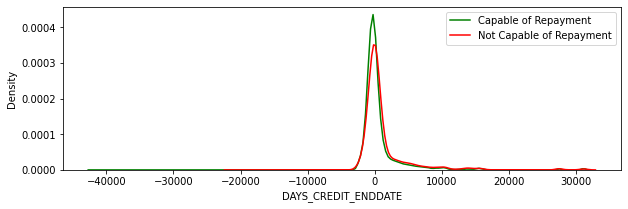

In [222]:
days_credit_end_approved = data[data['TARGET'] == 0]['DAYS_CREDIT_ENDDATE']
days_credit_end_rejected = data[data['TARGET'] == 1]['DAYS_CREDIT_ENDDATE']
plt.figure(figsize=(10,3))
sns.distplot(days_credit_end_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(days_credit_end_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

We will remove this columns since most of values are 0

In [223]:
data.drop('DAYS_CREDIT_ENDDATE', axis=1, inplace=True)

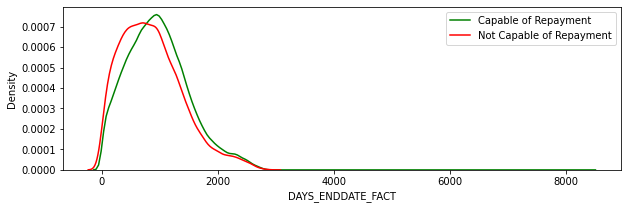

In [224]:
days_credit_approved = - data[data['TARGET'] == 0]['DAYS_ENDDATE_FACT']
days_credit_rejected = - data[data['TARGET'] == 1]['DAYS_ENDDATE_FACT']
plt.figure(figsize=(10,3))
sns.distplot(days_credit_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(days_credit_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

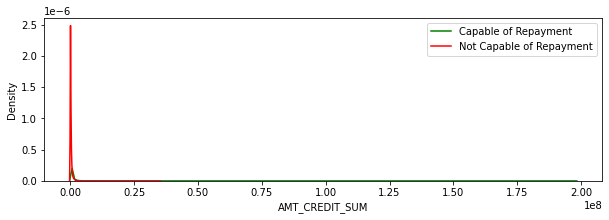

In [225]:
credit_sum_approved = data[data['TARGET'] == 0]['AMT_CREDIT_SUM']
credit_sum_rejected = data[data['TARGET'] == 1]['AMT_CREDIT_SUM']
plt.figure(figsize=(10,3))
sns.distplot(credit_sum_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(credit_sum_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

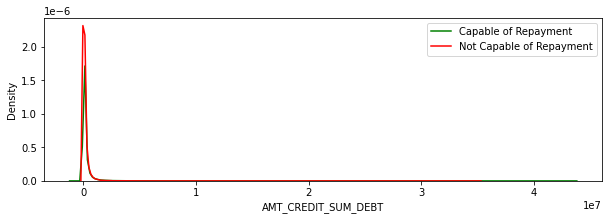

In [226]:
credit_sum_debt_approved = data[data['TARGET'] == 0]['AMT_CREDIT_SUM_DEBT']
credit_sum_debt_rejected = data[data['TARGET'] == 1]['AMT_CREDIT_SUM_DEBT']
plt.figure(figsize=(10,3))
sns.distplot(credit_sum_debt_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(credit_sum_debt_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

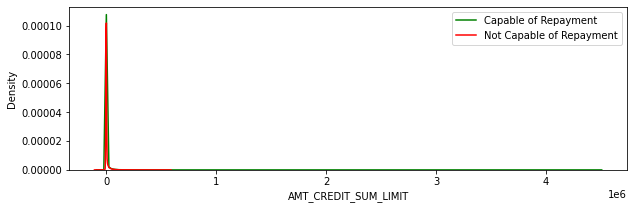

In [227]:
credit_sum_limit_approved = data[data['TARGET'] == 0]['AMT_CREDIT_SUM_LIMIT']
credit_sum_limit_rejected = data[data['TARGET'] == 1]['AMT_CREDIT_SUM_LIMIT']
plt.figure(figsize=(10,3))
sns.distplot(credit_sum_limit_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(credit_sum_limit_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

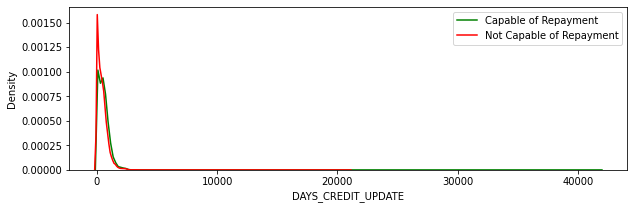

In [228]:
days_update_approved = - data[data['TARGET'] == 0]['DAYS_CREDIT_UPDATE']
days_update_rejected = - data[data['TARGET'] == 1]['DAYS_CREDIT_UPDATE']
plt.figure(figsize=(10,3))
sns.distplot(days_update_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(days_update_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

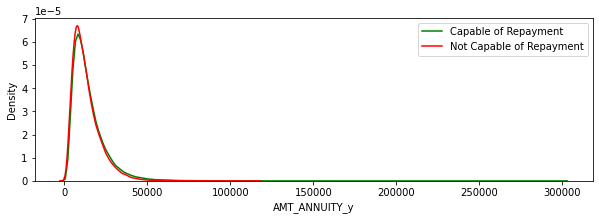

In [229]:
annuity_cb_approved = data[data['TARGET'] == 0]['AMT_ANNUITY_y']
annuity_cb_rejected = data[data['TARGET'] == 1]['AMT_ANNUITY_y']
plt.figure(figsize=(10,3))
sns.distplot(annuity_cb_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(annuity_cb_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

Since the distributions are almost the same, we will remove this column

In [230]:
data.drop('AMT_ANNUITY_y', axis=1, inplace=True)

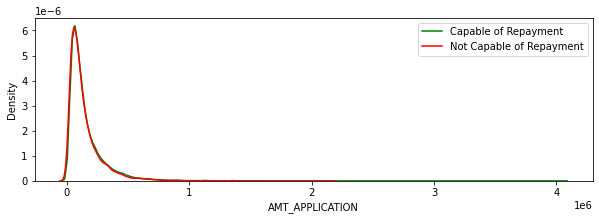

In [231]:
amt_app_approved = data[data['TARGET'] == 0]['AMT_APPLICATION']
amt_app_rejected = data[data['TARGET'] == 1]['AMT_APPLICATION']
plt.figure(figsize=(10,3))
sns.distplot(amt_app_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(amt_app_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

In [232]:
data.drop('AMT_APPLICATION', axis=1, inplace=True)

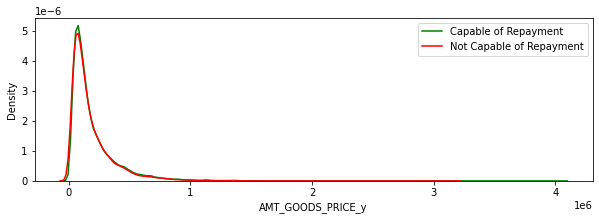

In [233]:
amt_goodsprice_pv_approved = data[data['TARGET'] == 0]['AMT_GOODS_PRICE_y']
amt_goodsprice_pv_rejected = data[data['TARGET'] == 1]['AMT_GOODS_PRICE_y']
plt.figure(figsize=(10,3))
sns.distplot(amt_goodsprice_pv_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(amt_goodsprice_pv_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

In [234]:
data.drop('AMT_GOODS_PRICE_y', axis=1, inplace=True)

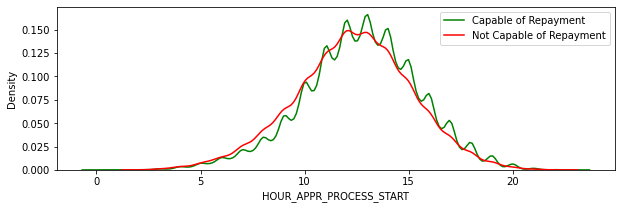

In [235]:
hour_appr_approved = data[data['TARGET'] == 0]['HOUR_APPR_PROCESS_START']
hour_appr_rejected = data[data['TARGET'] == 1]['HOUR_APPR_PROCESS_START']
plt.figure(figsize=(10,3))
sns.distplot(hour_appr_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(hour_appr_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

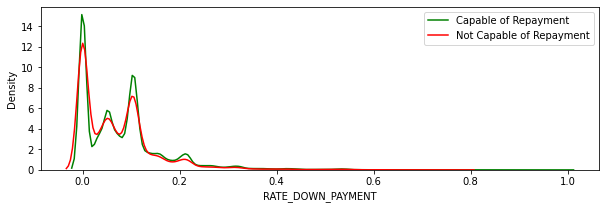

In [236]:
rate_down_payment_approved = data[data['TARGET'] == 0]['RATE_DOWN_PAYMENT']
rate_down_payment_rejected = data[data['TARGET'] == 1]['RATE_DOWN_PAYMENT']
plt.figure(figsize=(10,3))
sns.distplot(rate_down_payment_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(rate_down_payment_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

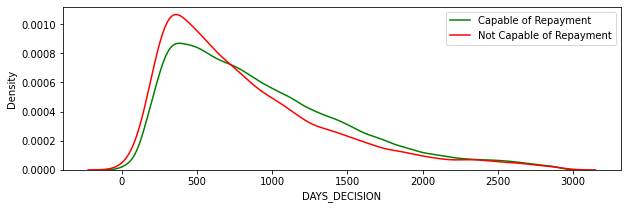

In [237]:
days_decision_approved = - data[data['TARGET'] == 0]['DAYS_DECISION']
days_decision_rejected = - data[data['TARGET'] == 1]['DAYS_DECISION']
plt.figure(figsize=(10,3))
sns.distplot(days_decision_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(days_decision_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

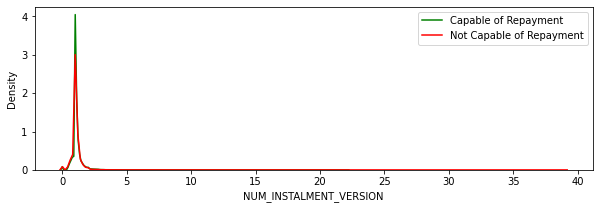

In [238]:
num_install_ver_approved = data[data['TARGET'] == 0]['NUM_INSTALMENT_VERSION']
num_install_ver_rejected = data[data['TARGET'] == 1]['NUM_INSTALMENT_VERSION']
plt.figure(figsize=(10,3))
sns.distplot(num_install_ver_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(num_install_ver_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

In [239]:
data.drop('NUM_INSTALMENT_VERSION', axis=1, inplace=True)

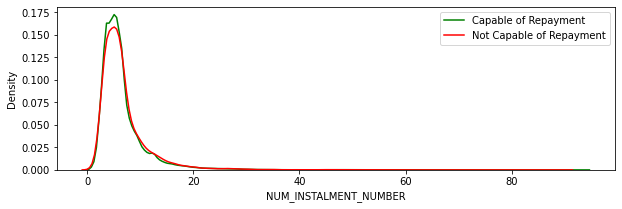

In [240]:
num_install_num_approved = data[data['TARGET'] == 0]['NUM_INSTALMENT_NUMBER']
num_install_num_rejected = data[data['TARGET'] == 1]['NUM_INSTALMENT_NUMBER']
plt.figure(figsize=(10,3))
sns.distplot(num_install_num_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(num_install_num_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

In [241]:
data.drop('NUM_INSTALMENT_NUMBER', axis=1, inplace=True)

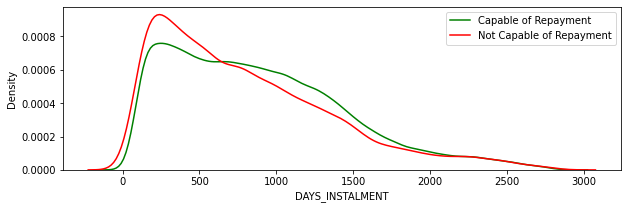

In [242]:
days_install_approved = - data[data['TARGET'] == 0]['DAYS_INSTALMENT']
days_install_rejected = - data[data['TARGET'] == 1]['DAYS_INSTALMENT']
plt.figure(figsize=(10,3))
sns.distplot(days_install_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(days_install_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

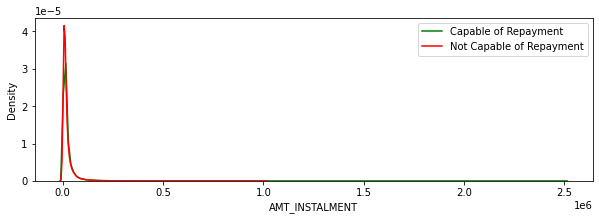

In [243]:
amt_install_approved = data[data['TARGET'] == 0]['AMT_INSTALMENT']
amt_install_rejected = data[data['TARGET'] == 1]['AMT_INSTALMENT']
plt.figure(figsize=(10,3))
sns.distplot(amt_install_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(amt_install_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

In [244]:
data.drop('AMT_INSTALMENT', axis=1, inplace=True)

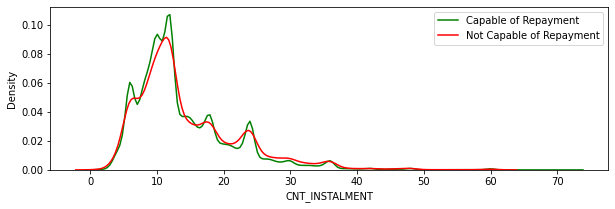

In [245]:
cnt_install_approved = data[data['TARGET'] == 0]['CNT_INSTALMENT']
cnt_install_rejected = data[data['TARGET'] == 1]['CNT_INSTALMENT']
plt.figure(figsize=(10,3))
sns.distplot(cnt_install_approved,hist=False,label="Capable of Repayment", color='green')
sns.distplot(cnt_install_rejected,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

In [246]:
data.shape

(307511, 42)

In [247]:
data.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_3',
       'PREVIOUS_LOANS_COUNT', 'DAYS_CREDIT', 'DAYS_ENDDATE_FACT',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'DAYS_CREDIT_UPDATE', 'PREVIOUS_APPLICATION_COUNT',
       'HOUR_APPR_PROCESS_START', 'RATE_DOWN_PAYMENT', 'DAYS_DECISION',
       'DAYS_INSTALMENT', 'CNT_INSTALMENT'],
      dtype='object')

In [248]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_CREDIT_x,AMT_ANNUITY_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT_UPDATE,PREVIOUS_APPLICATION_COUNT,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,DAYS_DECISION,DAYS_INSTALMENT,CNT_INSTALMENT
0,100002.0,1.0,Cash loans,M,406597.5,24700.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,...,108131.945625,49156.2,7997.14125,-499.875,1.0,9.000000,0.000000,-606.000000,-295.000000,24.000000
1,100003.0,0.0,Cash loans,F,1293502.5,35698.5,Family,State servant,Higher education,Married,...,254350.125000,0.0,202500.00000,-816.000,3.0,14.666667,0.050030,-1305.000000,-1164.333333,9.791667
2,100004.0,0.0,Revolving loans,M,135000.0,6750.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,...,94518.900000,0.0,0.00000,-532.000,1.0,5.000000,0.212008,-815.000000,-754.000000,3.750000
3,100006.0,0.0,Cash loans,F,312682.5,29686.5,Unaccompanied,Working,Secondary / secondary special,Civil marriage,...,NaN,NaN,NaN,NaN,9.0,14.666667,0.163412,-272.444444,-260.666667,12.888889
4,100007.0,0.0,Cash loans,M,513000.0,21865.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,...,146250.000000,0.0,0.00000,-783.000,6.0,12.333333,0.159516,-1222.833333,-1087.881319,15.066667
